In [7]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchmetrics import R2Score

r2score = R2Score()

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=4)

In [8]:
# Hyperparameters
p = 8   # size of branch and trunk ouput
n = 4   # horizon window length
H = 51  # maximum window length

In [9]:
# Model
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    # Branch x0
    self.input_x0   = torch.nn.Linear(1, 8)
    self.hidden1_x0 = torch.nn.Linear(8, 8)
    self.output_x0  = torch.nn.Linear(8, p)

    # Branch u
    self.input_u    = torch.nn.Linear(n, 8)
    self.hidden1_u  = torch.nn.Linear(8, 8)
    self.output_u   = torch.nn.Linear(8, p)

    # Trunk
    self.input_t    = torch.nn.Linear(1, 8)
    self.hidden1_t  = torch.nn.Linear(8, 8)
    self.output_t   = torch.nn.Linear(8, p)

  def forward(self, x0, u, t):
    h = self.input_x0(x0)
    h = self.hidden1_x0(h)
    h = self.output_x0(h)

    f = self.input_u(u)
    f = self.hidden1_u(f)
    f = self.output_u(f)

    g = self.input_t(t)
    g = self.hidden1_t(g)
    g = self.output_t(g)

    return torch.sum(h*f*g + x0, dim=1).reshape(-1,1)

In [10]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x0_data, testset.u_data, testset.t_data)

    r2 = r2score(pred_Y, testset.y_data)
    return r2.item()

In [11]:
# Create network
device = torch.device("cpu")
net = Net().to(device)

In [12]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file):
    df = pd.read_csv(src_file, header=None)

    X0, U, T, Y = np.array([[1]], dtype=np.float32), np.ones((1, n)), np.array([[1]], dtype=np.float32), np.array([[1]], dtype=np.float32)

    for i in range(df.shape[0]):
        row = np.array(df.iloc[i])
        for j in range(H-n):
            x0 = np.array([[row[H+j]]])
            u  = np.array([row[j:j+n]])
            for t in range(1, n+1):
                y = np.array([[row[H+j+t]]])
                t = np.array([[t]])

                X0 = np.concatenate((X0, x0))
                U  = np.concatenate((U, u))
                T  = np.concatenate((T, t))
                Y  = np.concatenate((Y, y))

    X0, U, T, Y = X0[1:], U[1:], T[1:], Y[1:]

    self.x0_data = torch.tensor(X0, dtype=torch.float32)
    self.u_data  = torch.tensor(U, dtype=torch.float32)
    self.t_data  = torch.tensor(T, dtype=torch.float32)
    self.y_data  = torch.tensor(Y, dtype=torch.float32)

  def __len__(self):
    return len(self.x0_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    x0  = self.x0_data[idx]
    u   = self.u_data[idx]
    t   = self.t_data[idx]
    y   = self.y_data[idx]
    sample = {'x0':x0, 'u':u, 't':t, 'y':y}
    return sample

# Create Dataset and DataLoader objects
src_file_train = 'C:/Users/tln229/Downloads/Python/2. DeepONets/0. Data/data.csv'
train_ds       = Data(src_file_train)

src_file_test = 'C:/Users/tln229/Downloads/Python/2. DeepONets/0. Data/data_5.csv'
test_ds       = Data(src_file_test)

In [13]:
# Early stopping
def early_stop(list, min_epochs, patience):
    if(len(list) > min_epochs):
        if(np.max(list[-patience:]) < 1.005*np.max(list[0: -patience])):
            return 1
    return 0

In [14]:
# train model
max_epochs = 89
loss_func  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.01)

train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=train_ds.y_data.shape[0], shuffle=True)

R2_train = np.array([])
R2_test  = np.array([])
for epoch in range(0, max_epochs+1):
    net.train()
    loss  = 0
    count = 0
    for (_, batch) in enumerate(train_ldr):
        X0 = batch['x0']
        U  = batch['u']
        T  = batch['t']
        Y  = batch['y']

        optimizer.zero_grad()
        output = net(X0, U, T)             # compute the output of the Network
        loss_val = loss_func(output, Y)    # loss function
        loss += loss_val.item()            # accumulate
        loss_val.backward()                # gradients
        optimizer.step()                   # update paramters
        count += 1
    
    net.eval()
    R2_train = np.append(R2_train, eval(net, train_ds))
    R2_test  = np.append(R2_test, eval(net, test_ds))

    if(epoch%5==0):
        print("epoch = %5d \t loss = %9.5f \t R2_train = %9.5f \t R2_test = %9.5f" % (epoch, loss/count, eval(net, train_ds), eval(net, test_ds)))
    
    if(early_stop(list = R2_test, min_epochs = 100, patience = 50) == 1):
        break

epoch =     0 	 loss = 160.37013 	 R2_train = -48.82444 	 R2_test = -79.78338
epoch =     5 	 loss = 139.69164 	 R2_train = -39.90213 	 R2_test = -64.48621
epoch =    10 	 loss =  43.57347 	 R2_train =  -7.51087 	 R2_test = -12.81693
epoch =    15 	 loss =  27.78143 	 R2_train =  -6.25064 	 R2_test = -11.14159
epoch =    20 	 loss =  32.00378 	 R2_train =  -8.36871 	 R2_test = -11.89840
epoch =    25 	 loss =  14.79148 	 R2_train =  -4.16669 	 R2_test =  -9.68514
epoch =    30 	 loss =  11.64134 	 R2_train =  -2.14086 	 R2_test =  -4.33274
epoch =    35 	 loss =   9.86062 	 R2_train =  -1.55307 	 R2_test =  -2.19851
epoch =    40 	 loss =   4.41613 	 R2_train =  -0.28383 	 R2_test =  -2.40588
epoch =    45 	 loss =   1.63802 	 R2_train =   0.38760 	 R2_test =   0.73817
epoch =    50 	 loss =   1.96742 	 R2_train =   0.42817 	 R2_test =  -0.71929
epoch =    55 	 loss =   1.24086 	 R2_train =   0.76352 	 R2_test =   0.83465
epoch =    60 	 loss =   0.54804 	 R2_train =   0.88356 	 R2_tes

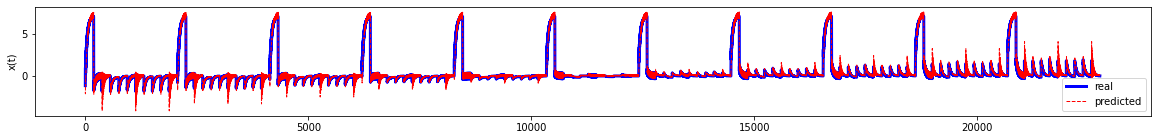

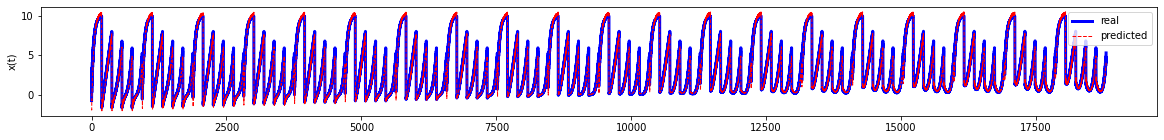

In [15]:
def plot(dataset, size):
    with torch.no_grad():
        pred_Y = net(dataset.x0_data, dataset.u_data, dataset.t_data)

    plt.figure(figsize=size)
    plt.plot(dataset.y_data, 'b',   label=r'real',      linewidth=3)
    plt.plot(pred_Y,         'r--', label=r'predicted', linewidth=1)
    plt.ylabel(r'x(t)')
    plt.legend()
    plt.show()

plot(train_ds, (20,2))
plot(test_ds, (20,2))

In [16]:
print(np.argmax(R2_test))
print(np.max(R2_test))

89
0.9824134707450867


In [17]:
PATH = 'C:/Users/tln229/Downloads/Python/2. DeepONets/0. Saved models/Unstacked.pt'
torch.save(net, PATH)